In [45]:
import requests
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import copernicusmarine
from pprint import pprint
import numpy as np
import xesmf as xe
import gsw

In [46]:
def t_from_pt0(SA, pt0, p): 
    p0 = np.zeros_like(SA);
    t = gsw.pt_from_t(SA,pt0,p0,p);
    return t

In [289]:
import xarray as xr
import pandas as pd

def truncate_to_month(ds, time_var='time'):
    """
    Truncate the datetime values of the time dimension to the start of the month.
    
    Parameters:
    - ds: xarray.Dataset or xarray.DataArray, the dataset or dataarray containing the time variable.
    - time_var: str, the name of the time variable to truncate.
    
    Returns:
    - ds: The modified xarray.Dataset or xarray.DataArray with truncated time values.
    """
    # Convert the time variable to a pandas datetime index, truncate to the first of the month
    truncated_time = ds[time_var].dt.strftime('%Y-%m-15')
    
    # Convert back to datetime
    truncated_time = xr.DataArray(pd.to_datetime(truncated_time), dims=ds[time_var].dims)
    
    # Assign the truncated time back to the dataset or dataarray
    ds[time_var] = truncated_time
    
    return ds

# Example usage:
# Assuming ds is your xarray Dataset or DataArray
# truncated_ds = truncate_to_month(ds)


In [290]:
glorys = xr.open_dataset("glorys_temp.zarr", engine = "zarr").isel(depth = 0).drop("depth")
glorys = glorys.rename({"latitude":"lat", "longitude":"lon"})
buoys = xr.open_dataset("NDBC_CC_daily.nc").resample(time = "1M").mean()
buoys = buoys.where(buoys.wtemp_density > 75, drop = True)
buoys_locs = buoys[["latitude", "longitude"]].rename({"latitude":"lat", "longitude":"lon"})
buoys_locs = buoys_locs.isel(time = 0).drop("time")

/var/folders/xc/1pgd3mgn7qjdv8bmcggt31j40000gn/T/ipykernel_17682/4027068917.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  glorys = xr.open_dataset("glorys_temp.zarr", engine = "zarr").isel(depth = 0).drop("depth")
/Users/anthonymeza/miniforge3/lib/python3.10/site-packages/xarray/groupers.py:326: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/var/folders/xc/1pgd3mgn7qjdv8bmcggt31j40000gn/T/ipykernel_17682/4027068917.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  buoys_locs = buoys_locs.isel(time = 0).drop("time")


In [291]:
glorys["theta"] = (("time", "lat", "lon"), t_from_pt0(glorys.so.values, glorys.thetao.values, 1))

In [292]:
regridder = xe.Regridder(glorys, buoys_locs, "bilinear", locstream_out=True)
glorys_locs = regridder(glorys).rename({"theta":"WTMP"})

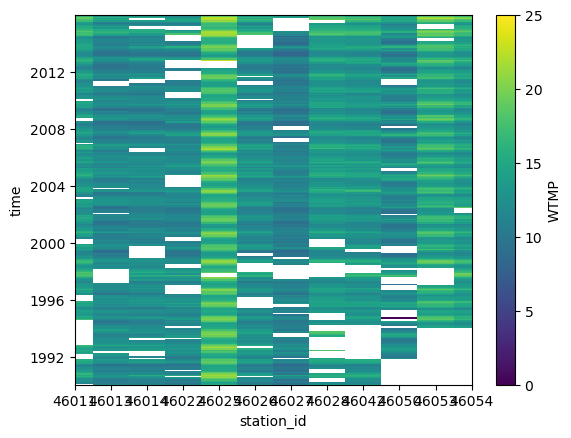

In [293]:
buoys.WTMP.plot(vmin = 0, vmax = 25)

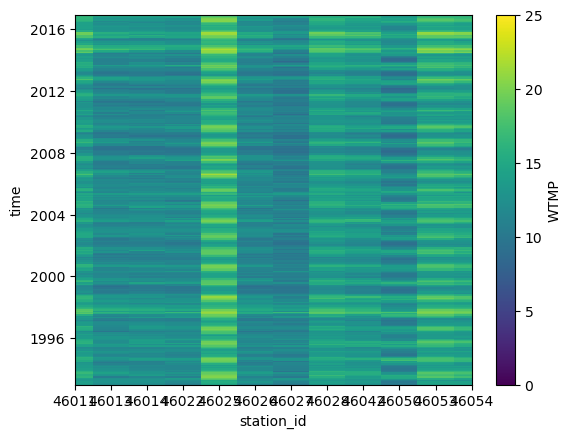

In [294]:
glorys_locs.WTMP.plot(vmin = 0, vmax = 25)

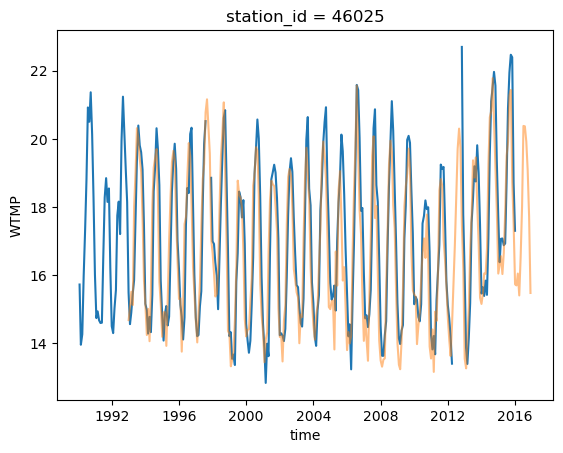

In [295]:
buoys.sel(station_id = "46025").WTMP.plot()
glorys_locs.sel(station_id = "46025").WTMP.plot(alpha = 0.5)

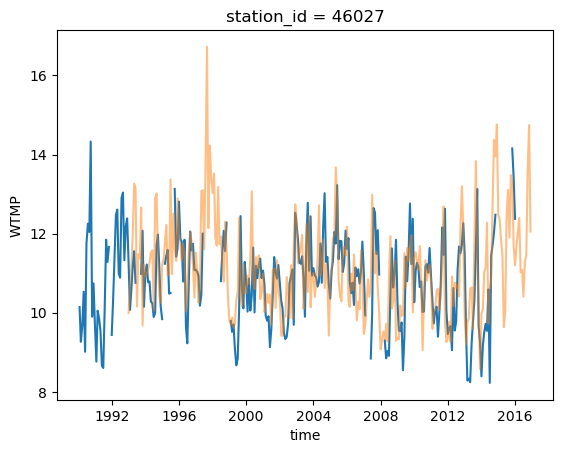

In [296]:
buoys.sel(station_id = "46027").WTMP.plot()
glorys_locs.sel(station_id = "46027").WTMP.plot(alpha = 0.5)

In [297]:
glorys_locs = truncate_to_month(glorys_locs)
buoys = truncate_to_month(buoys)

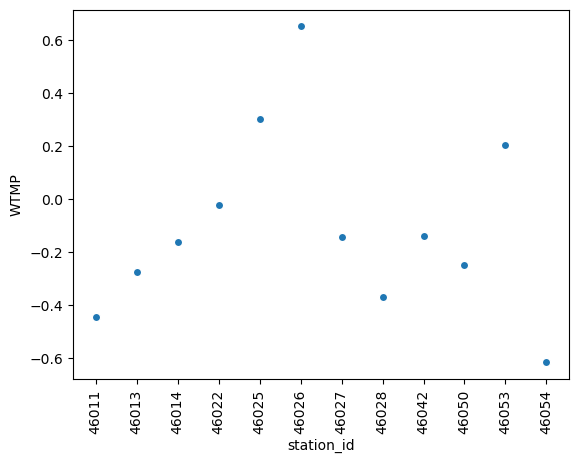

In [298]:
bias = (buoys.WTMP - glorys_locs.WTMP).mean("time")
bias.plot.scatter()
plt.xticks(rotation=90);


In [299]:
bias.station_id[bias.argmin(dim = "station_id")]

<xarray.DataArray 'station_id' ()> Size: 20B
array('46054', dtype='<U5')
Coordinates:
    station_id  <U5 20B '46054'

In [300]:
import xarray as xr
import numpy as np

def xr_correlation_old(a, b, dim = "time"):
    """
    Compute the Pearson correlation coefficient between two xarray DataArrays
    along a given dimension, ignoring NaN values.
    
    Parameters:
    - a: xarray.DataArray
    - b: xarray.DataArray
    - dim: str, the dimension along which to compute the correlation
    
    Returns:
    - xarray.DataArray of the correlation coefficients
    """
    # Ensure that a and b are DataArrays and they have the same dimensions
    if not isinstance(a, xr.DataArray) or not isinstance(b, xr.DataArray):
        raise ValueError("Inputs must be xarray DataArrays")
    if a.dims != b.dims:
        raise ValueError("Input DataArrays must have the same dimensions")
    
    # Align the two arrays to ensure they have the same shape and NaN values are aligned
    a, b = xr.align(a, b, join='inner')
    
    # Compute the mean of a and b, ignoring NaNs
    a_mean = a.mean(dim=dim, skipna=True)
    b_mean = b.mean(dim=dim, skipna=True)
    
    # Compute the deviation from the mean
    a_dev = a - a_mean
    b_dev = b - b_mean
    
    # Compute the covariance, ignoring NaNs
    cov_ab = (a_dev * b_dev).sum(dim=dim, skipna=True)
    
    # Compute the standard deviations, ignoring NaNs
    a_std = np.sqrt((a_dev ** 2).sum(dim=dim, skipna=True))
    b_std = np.sqrt((b_dev ** 2).sum(dim=dim, skipna=True))
    
    # Compute the correlation
    correlation = cov_ab / (a_std * b_std)
    
    return correlation

# Example usage:
# Assuming da1 and da2 are xarray DataArrays with a shared dimension 'time'
# correlation = xr_correlation(da1, da2, dim='time')


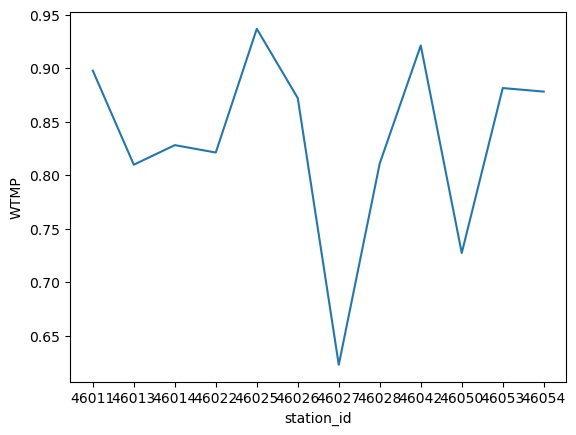

In [301]:
xr_correlation_old(buoys.WTMP, glorys_locs.WTMP, dim = "time").plot()

In [302]:
import xarray as xr
import numpy as np

def xr_correlation(a, b, dim):
    """
    Compute the Pearson correlation coefficient between two xarray DataArrays
    along a given dimension, ignoring NaN values and handling non-overlapping times.
    
    Parameters:
    - a: xarray.DataArray
    - b: xarray.DataArray
    - dim: str, the dimension along which to compute the correlation (e.g., 'time')
    
    Returns:
    - xarray.DataArray of the correlation coefficients
    """
    # Align the two arrays on the specified dimension, only keeping the overlapping part
    a_aligned, b_aligned = xr.align(a, b, join='inner')

    # Mask invalid (NaN) values
    valid_mask = np.isfinite(a_aligned) * np.isfinite(b_aligned)

    # Compute mean of valid values
    a_mean = a_aligned.where(valid_mask).mean(dim=dim, skipna=True)
    b_mean = b_aligned.where(valid_mask).mean(dim=dim, skipna=True)
    
    # Compute deviations from the mean
    a_dev = a_aligned - a_mean
    b_dev = b_aligned - b_mean
    
    # Compute covariance, ignoring NaNs
    cov_ab = (a_dev * b_dev).where(valid_mask).sum(dim=dim, skipna=True)
    
    # Compute standard deviations, ignoring NaNs
    a_std = np.sqrt((a_dev ** 2).where(valid_mask).sum(dim=dim, skipna=True))
    b_std = np.sqrt((b_dev ** 2).where(valid_mask).sum(dim=dim, skipna=True))
    
    # Compute correlation
    correlation = cov_ab / (a_std * b_std)
    
    return correlation

# Example usage:
# Assuming da1 and da2 are xarray DataArrays with a shared dimension 'time'
# correlation = xr_correlation(da1, da2, dim='time')


/var/folders/xc/1pgd3mgn7qjdv8bmcggt31j40000gn/T/ipykernel_17682/4024029771.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(0.0, 1.0)

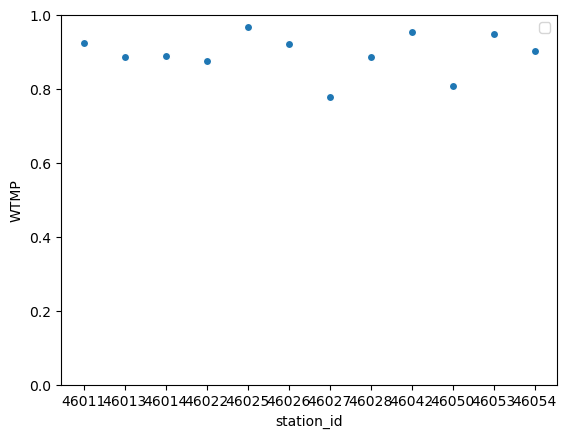

In [308]:
xr_correlation(buoys.WTMP, glorys_locs.WTMP, "time").plot.scatter()
plt.legend()
plt.ylim(0, 1)

In [304]:
minloc = xr_correlation(buoys.WTMP, glorys_locs.WTMP, "time").argmin()
xr_correlation(buoys.WTMP, glorys_locs.WTMP, "time").isel(station_id = minloc)


<xarray.DataArray 'WTMP' ()> Size: 8B
array(0.77834346)
Coordinates:
    station_id  <U5 20B '46027'

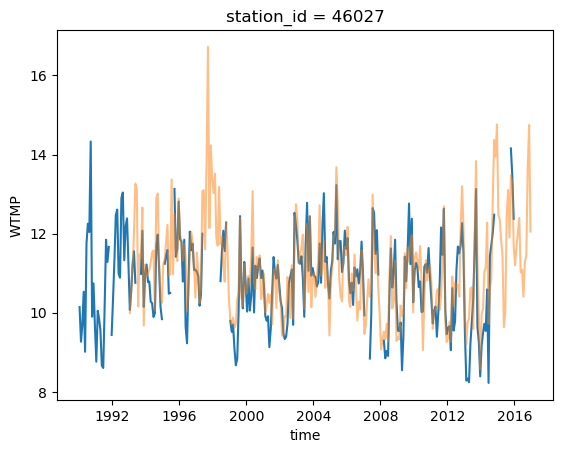

In [305]:
buoys.sel(station_id = "46027").WTMP.plot()
glorys_locs.sel(station_id = "46027").WTMP.plot(alpha = 0.5)